In this tutorial, we combine Genome-wide Association Study (GWAS) results with our STARNet-inferred GRNs to understand how genetic mutations (SNPs) associated with specific diseases function within particular brain regions and influence gene regulatory networks.

Song, L., Chen, W., Hou, J. et al. Spatially resolved mapping of cells associated with human complex traits. Nature 641, 932–941 (2025). https://doi.org/10.1038/s41586-025-08757-x

In [1]:
import matplotlib.pyplot as plt
import STARNet as ST
import omicverse as ov
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import os

def rotate_points_90_degrees_counterclockwise(points):
    rotated_points = np.array([-points[:, 1], points[:, 0]]).T
    return rotated_points

/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


### Spatial Transcriptomics Data Preparation

First, we load either our provided dataset or your trained human hippocampus spatial transcriptomics data.

Also, you may need the gsMap result of this data in the [Links to Data Folder](https://drive.google.com/drive/folders/1obqewcAAvcUi8WOhqomKDo7BO_GncNvP?usp=sharing).

In [ ]:
adata_rna = sc.read_h5ad('Drive/Datasets/Human_Hippocampus/Process_Data/adata_rna_trained.h5ad')
adata_rna.uns['grn'] = {}
adata_rna.uns['grn']['adata_nlog10_pval'] = sc.read_h5ad("Drive/Datasets/Human_Hippocampus/Process_Data/human_hippocampus_grn_nlog10_pval.adata").T
adata_rna.obs_names = [i.split('-')[0] for i in adata_rna.obs_names ]

TF_module = ov.utils.load('Drive/Datasets/Human_Hippocampus/Process_Data/TF_module_leiden_2.pkl')
adata_rna.uns['TF_module'] = TF_module
adata_rna

AnnData object with n_obs × n_vars = 2500 × 15923
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'pct_cells', 'chrom', 'chromStart', 'chromEnd', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Origin_Peak2Gene', 'Peak2Gene', 'disc',

> ⚠️ **Note**  
> Because of minor variations in the **embedding** process, the **Leiden clustering** results may not be identical to the provided example.  
> Please carefully validate the correspondence between the **clustering assignments** and the **spatial transcriptomics annotation labels**.

We then annotate and visualize the spatial domains of the hippocampus. Note that `cluster2annotation_new` combines CA3-4 and GCL regions for the Cauchy combination test.

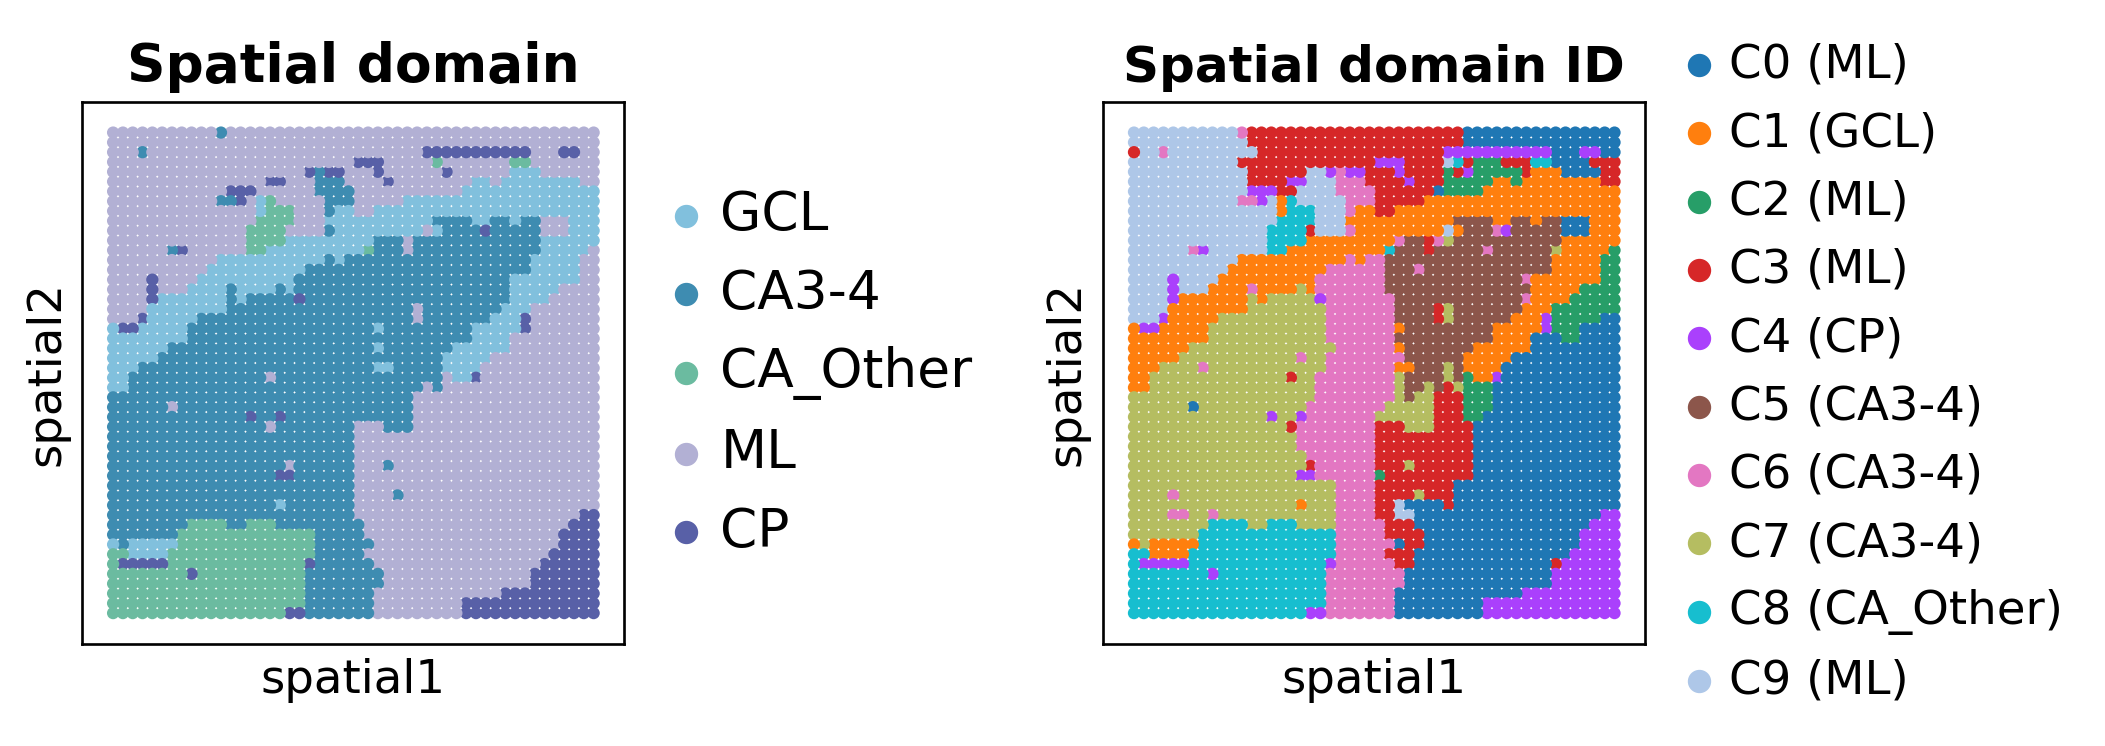

In [3]:
adata_rna.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(adata_rna.obsm['spatial'])

cluster2annotation_ID = {
    '0': 'C0 (ML)',
    '1': 'C1 (GCL)',
    '2': 'C2 (ML)',
    '3': 'C3 (ML)',
    '4': 'C4 (CP)',
    '5': 'C5 (CA3-4)',
    '6': 'C6 (CA3-4)',
    '7': 'C7 (CA3-4)',
    '8': 'C8 (CA_Other)',
    '9': 'C9 (ML)',
}

cluster2annotation = {
    '0': 'ML',
    '1': 'GCL',
    '2': 'ML',
    '3': 'ML',
    '4': 'CP',
    '5': 'CA3-4',
    '6': 'CA3-4',
    '7': 'CA3-4',
    '8': 'CA_Other',
    '9': 'ML',
}

cluster2annotation_new = {
    '0': 'ML',
    '1': 'CA3-4 & GCL',
    '2': 'ML',
    '3': 'ML',
    '4': 'CP',
    '5': 'CA3-4 & GCL',
    '6': 'CA3-4 & GCL',
    '7': 'CA3-4 & GCL',
    '8': 'CA_Other',
    '9': 'ML',
}

adata_rna.obs['spatial domain ID'] = adata_rna.obs['leiden'].map(cluster2annotation_ID).astype('category')
adata_rna.obs['spatial domain'] = adata_rna.obs['leiden'].map(cluster2annotation).astype('category')
adata_rna.obs['spatial domain new'] = adata_rna.obs['leiden'].map(cluster2annotation_new).astype('category')

adata_rna.uns['spatial domain_colors'] = ov.utils.blue_color[2:4] + [ov.utils.blue_color[1]] +  ov.utils.blue_color[7:9]
adata_rna.obs['spatial domain'] = adata_rna.obs['spatial domain'].cat.reorder_categories(['GCL', 'CA3-4', 'CA_Other','ML','CP'])

fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

sc.pl.spatial(adata_rna,
              color=['spatial domain'], 
              colorbar_loc=None,
              spot_size=1.25,
              legend_fontsize=16,
              ax=axes[0],
              show=False)
axes[0].set_title('Spatial domain', fontweight='bold', fontsize=16)

sc.pl.spatial(adata_rna,
              color=['spatial domain ID'], 
              colorbar_loc=None,
              spot_size=1.25,
              legend_fontsize=14,
              ax=axes[1],
              show=False)
axes[1].set_title('Spatial domain ID', fontweight='bold', fontsize=15)

plt.tight_layout()
plt.show()

### gsMap Result Preprocess

Here, we use the gsMap result on our Human Hippocampus data for further analysis. You can directly download our gsMap result from our Google Drive, or you can run gsMap manually via the official [gsMap tutorial](https://yanglab.westlake.edu.cn/gsmap/home).

In [ ]:
# You need to run gsMap first to generate the results.
# gsmap_result_path = "your/path/to/gsMap_result" 
gsmap_result_path = "Drive/Datasets/Human_Hippocampus/Process_Data/gwas_report"
pval_df = pd.DataFrame(index=adata_rna.obs_names)

for root, dirs, files in os.walk(gsmap_result_path):
    if 'gsMap_plot' in dirs:
        gs_map_plot_path = os.path.join(root, 'gsMap_plot')
        for file in os.listdir(gs_map_plot_path):
            if file.endswith('.csv'):
                file_path = os.path.join(gs_map_plot_path, file)
                data= pd.read_csv(file_path,index_col=[0])
                pval_df[root.split('/')[-1]] = data.loc[adata_rna.obs_names,'p'].values
                
# save the result to a csv file
pval_df.to_csv('Drive/Datasets/Human_Hippocampus/Process_Data/gsMap_pval.csv')

Using the `ST.pp.calculate_cauchy_combination_test()`, we aggregate p-values from all points within a specific region for statistical analysis. This calculates the overall significance of each region's association with the trait.

In [ ]:
adata_rna.obs['p-value'] = pval_df.loc[adata_rna.obs_names,'Cognitive_Performance_2018_NatGenet']
p_tissue = ST.pp.calculate_cauchy_combination_test(adata_rna, pvalue='p-value', annotation='spatial domain')

result_dict = {}

for trait in pval_df.columns:
    adata_rna.obs['p-value'] = pval_df.loc[adata_rna.obs_names,trait]
    p_tissue = ST.pp.calculate_cauchy_combination_test(adata_rna, pvalue='p-value', annotation='spatial domain')
    
    p_tissue['annotation'] = pd.Categorical(p_tissue['annotation'], categories=['GCL', 'CA3-4', 'CA_Other', 'ML', 'CP'], ordered=True)
    p_tissue = p_tissue.sort_values(by='annotation')
    
    result_dict[trait] = p_tissue['nlog10_p_cauchy'].values

result_df = pd.DataFrame(result_dict, index=p_tissue['annotation'].values)
result_df.to_csv('Drive/Datasets/Human_Hippocampus/Process_Data/Cauchy_result.csv')

Here, we fliter the Cauchy test result to get significant meaningful result. (p-value > 5)

In [7]:
# Preprocess the result DataFrame

# result_df = pd.read_csv('Process_Data/Cauchy_result.csv',index_col=[0])
result_df = result_df.loc[:,result_df.gt(5).any(axis=0)]

In [8]:
result_df.columns

Index(['parsopercularis_area_sumstat', 'superiorparietal_area_sumstat',
       'SESA_neuro_clus_sumstats', 'ILAE3_Caucasian_GGE_final',
       'PGC_Bipolar_INFO80_2021_NatGenet', 'bip2024_eur_no23andMe',
       'GIANT_EUR_Height_2022_Nature', 'ADHD_2022_NatGenet',
       'Depression_2023_NatureMed', 'sumstats_neuroticism_ctg_format',
       'ADHD_adulthood_2022_NatGenet', 'precuneus_area_sumstat',
       'dorsolateralprefrontal_thickness_sumstat',
       'motorpremotor_area_sumstat', 'PGC3_SCZ_wave3_public_INFO80',
       'Cognitive_Performance_2018_NatGenet', 'medialprefrontal_thickness',
       'dorsomedialfrontal_area_sumstat', 'anteromedialtemporal_area_sumstat',
       'IQ_NG_2018', 'Insomnia_sumstats_Jansenetal', 'MDD_Howard_2019_NN',
       'ventralfrontal_thickness_sumstat', 'TS_Oct2018'],
      dtype='object')

We renamed all traits to improve visualization in later steps. Additionally, we filtered the traits to focus on a specific subset.

In [9]:
result_df.columns = ['POSA', 'SPSA', 'SESA', 'Epilepsies','BPG_Bip', 'BD', 
                          'Height', 'ADHD', 'Depression', 'Neuroticism', 'ADHD_AD', 
                          'PSA', 'DPCT', 'MPA', 'SCZ', 'CP', 'MPT', 'DPSA', 
                          'ATSA', 'IQ', 'Insomnia', 'MDD', 'VFCT', 'TS']
result_df = result_df.loc[:,['POSA', 'SPSA', 'SESA', 'Epilepsies', 'BD', 
                         'ADHD', 'Depression', 'Neuroticism', 
                          'PSA', 'DPCT', 'MPA', 'SCZ', 'CP', 'MPT', 'DPSA', 
                          'ATSA', 'IQ', 'Insomnia', 'VFCT', 'TS']]
result_df = result_df.sort_values(['GCL'],axis=1,ascending=False)
result_df 

,BD,SCZ,IQ,CP,Depression,Neuroticism,SESA,Insomnia,Epilepsies,ADHD,TS,DPSA,VFCT,DPCT,POSA,ATSA,PSA,SPSA,MPA,MPT
GCL,27.042240,25.010692,22.960358,22.544890,13.371391,11.180029,9.699980,7.053889,6.598417,6.320427,4.670647,1.904489,1.616693,1.064633,0.789646,0.472952,0.466415,0.388651,0.280887,0.227413
CA3-4,21.177150,22.791859,19.088171,22.497432,14.750470,12.177308,9.766770,8.454804,5.220452,9.356103,5.222098,1.460338,1.989331,0.851260,0.774341,0.217748,0.980169,0.765027,0.928998,0.756604
CA_Other,0.008669,0.499969,0.025121,0.007893,0.053954,0.288849,0.472357,0.035009,0.027994,0.211132,0.005211,1.379952,1.851395,1.623349,2.011863,1.430447,3.122297,2.334091,1.619709,1.730962
ML,0.031697,0.004737,0.017749,0.068840,0.025849,0.004353,0.000095,0.603395,0.004947,0.054282,0.017454,1.077300,3.073566,5.473941,1.625535,3.465442,2.410085,1.962487,0.635520,3.409682
CP,2.449203,5.134756,1.162352,2.379553,0.038331,1.016715,1.523886,1.062673,2.348275,1.081874,1.246879,5.453900,5.538473,3.395795,5.102583,5.472310,5.129241,5.231358,5.919370,7.587336


### Heatmap of Region vs Traits

This heatmap allows us to visualize how various traits are enriched across different spatial regions.

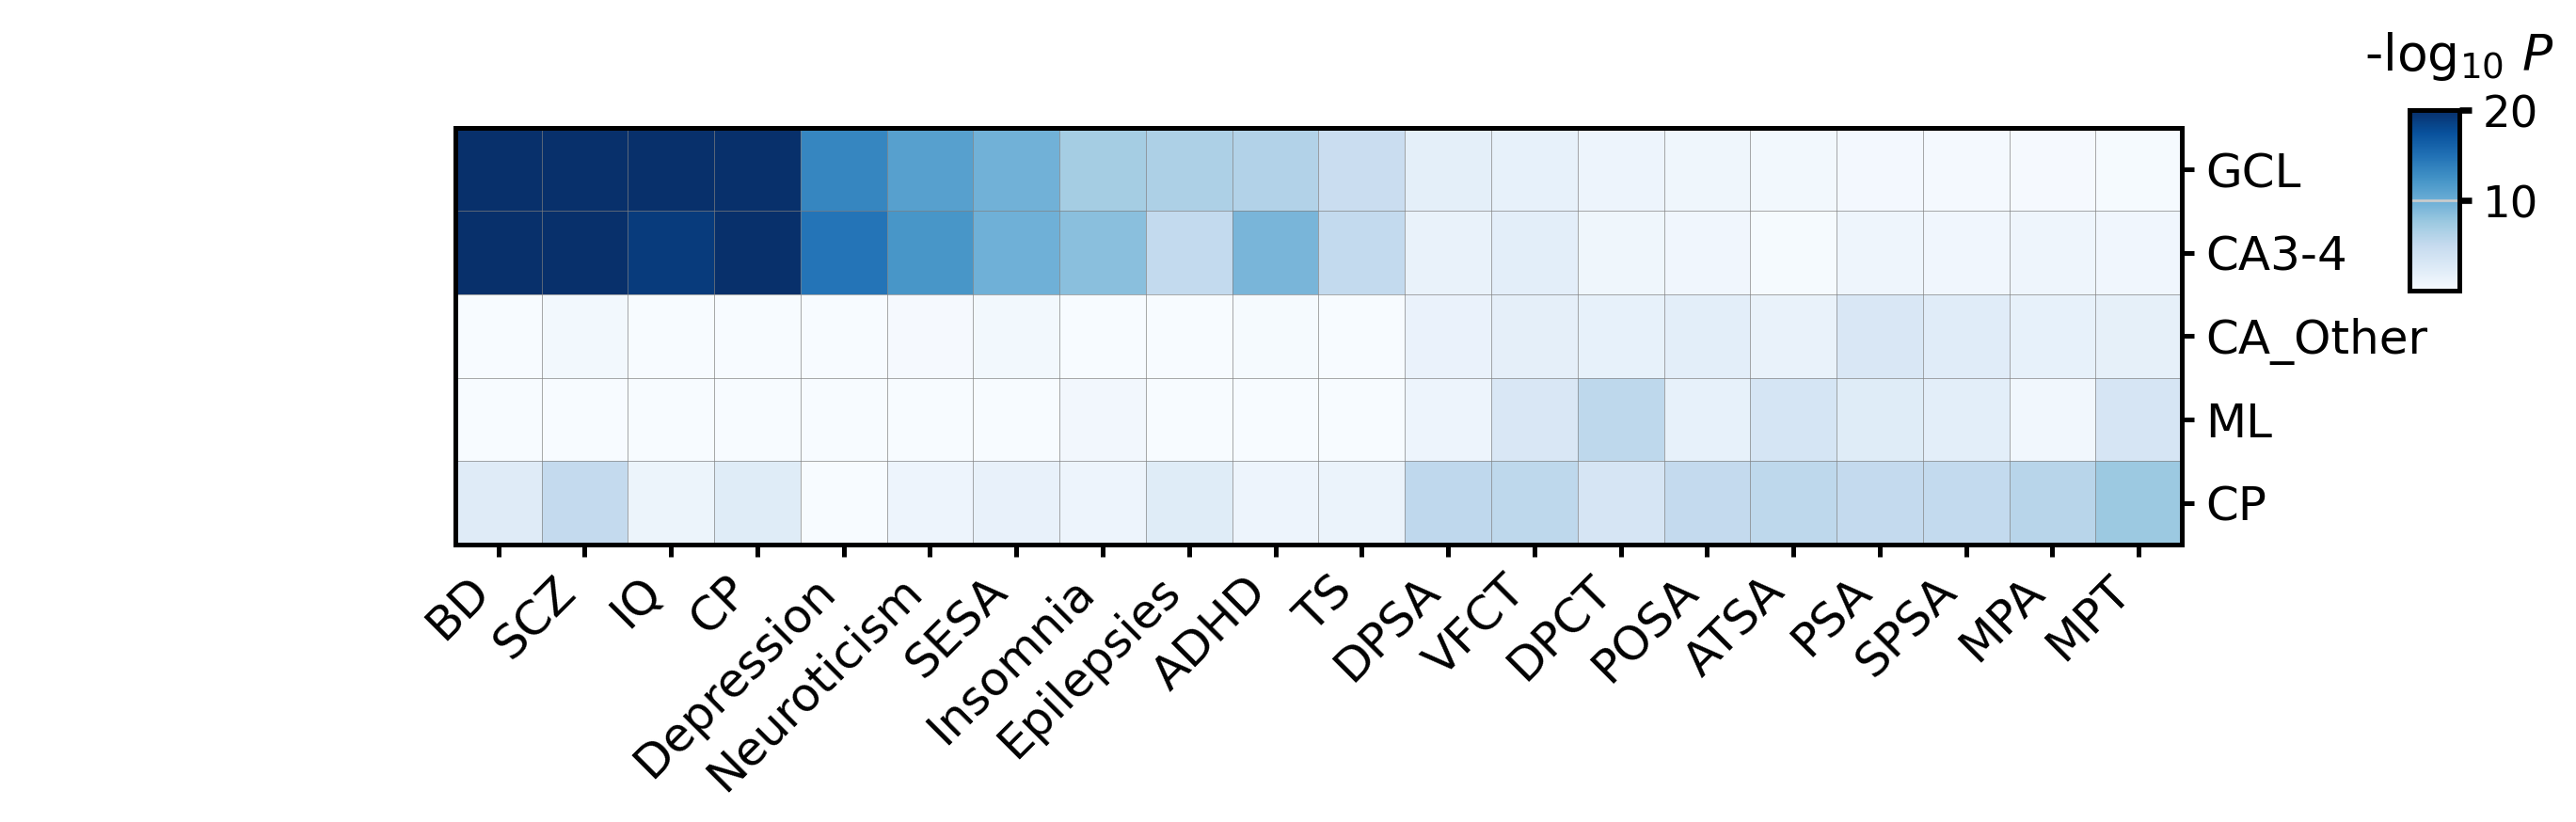

In [ ]:
# Create the heatmap
fig = ST.pl.create_gwas_heatmap(result_df)
plt.tight_layout()
plt.show()

### Dot plot of significant GRNs in specific region

Based on the scores from the Cauchy combination test, we can visualize the top k significant genes in specific regions. The dot plot displays aggregated p-values for all GRNs across individual spots in the GCL and CA3-4 regions. GRNs with p < 0.05 are designated as significant, and the top ten significant GRNs are labeled.

In [11]:
results_df = ST.pp.cal_cauchy_combination_test(adata_rna,annotation_col='spatial domain new')
results_df = results_df.apply(pd.to_numeric, errors='coerce')
results_df = results_df.apply(lambda x: x.fillna(0))
results_df.index = results_df.index + '(+)'
results_df

,CA3-4 & GCL,CA_Other,CP,ML
LCOR(+),0.531801,0.694789,0.553287,0.657627
ZNF441(+),0.625348,0.423493,0.300712,1.124835
POU2F2(+),0.771264,1.017375,0.745759,1.812517
ZSCAN16(+),0.639029,0.279211,0.110627,0.866008
ZNF3(+),0.366142,0.496694,1.103281,1.558493
...,...,...,...,...
ZNF84(+),0.687203,0.407974,0.089437,3.002239
ZNF486(+),0.308181,0.240381,0.445087,1.828646
HES6(+),1.404084,0.810261,0.834403,1.041375
ZFHX2(+),0.660996,0.295009,0.127404,1.075667


2025-07-31 06:31:35 - WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Text(0.5, 47.66666666666668, 'GRN rank')

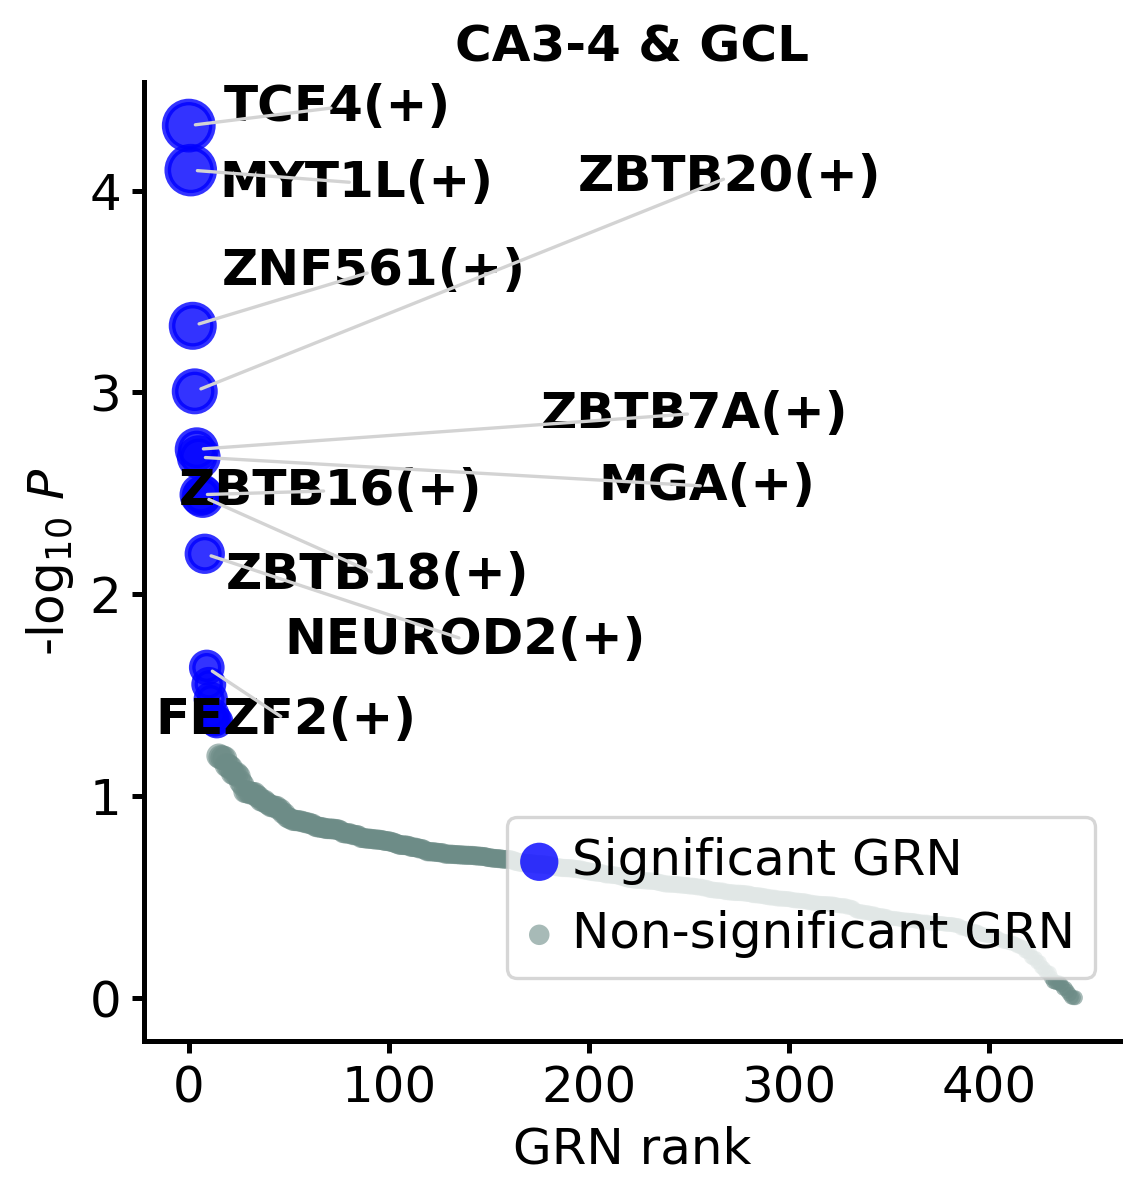

In [12]:
ax = ST.pl.plot_cauchy_combination_test(
    results_df, 
    n_top=10,
    spatial_domain = 'CA3-4 & GCL', 
 #   color_significant = '#B83945'6,
    color_non_significant = '#6D8C87',
    bbox_to_anchor = (1,0.15),
    fontsize=15,
    figsize=(5, 5), 
)
plt.title('CA3-4 & GCL',fontweight='bold',fontsize=15)
ax.tick_params(axis='x', labelsize=15, width=1.5,) 
ax.tick_params(axis='y', labelsize=15, width=1.5,) 
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
plt.ylabel("-log$_{10}$ $\it{P}$",fontsize=15)
plt.xlabel("GRN rank",fontsize=15)

### Spatial Visualization of Traits

In this step, we can examine where the specific trait-associated genes are located spatially.

In [ ]:
gsmap_pvalue = pd.read_csv("Drive/Datasets/Human_Hippocampus/Process_Data/gsMap_pval.csv",index_col=[0])
adata_rna.obs['p-value'] = gsmap_pvalue.loc[adata_rna.obs_names,'PGC3_SCZ_wave3_public_INFO80']
adata_rna.obs['logp'] = -np.log10(adata_rna.obs['p-value'])
adata_rna.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,...,n_genes,pct_genes,pct_mt,leiden,pre_clusters,spatial domain ID,spatial domain,spatial domain new,p-value,logp
AAACATCGAAACATCG,581,6.455199,476.093137,7.020191,34.525939,44.633274,61.091234,87.924866,0.0,0.0,...,634,0.029935,0,0,0,C0 (ML),ML,ML,9.999078e-01,0.000040
AAACATCGAACAACCA,3514,8.269501,744.073621,9.247829,15.326076,20.653116,28.330604,44.311723,0.0,0.0,...,3884,0.183389,0,1,1,C1 (GCL),GCL,CA3-4 & GCL,6.347232e-22,21.197416
AAACATCGAACCGAGA,514,6.322565,494.865626,6.782192,27.809308,40.408627,59.591373,93.643587,0.0,0.0,...,553,0.026111,0,2,2,C2 (ML),ML,ML,2.776192e-01,0.556550
AAACATCGAACGCTTA,365,5.983936,426.010848,6.480045,36.866359,52.534562,69.892473,100.000000,0.0,0.0,...,391,0.018462,0,2,0,C2 (ML),ML,ML,5.259168e-01,0.279083
AAACATCGAACGTGAT,193,5.356586,311.242909,5.783825,50.308642,65.740741,96.604938,100.000000,0.0,0.0,...,211,0.009963,0,0,0,C0 (ML),ML,ML,8.715168e-01,0.059724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCACATAGAATCTGA,239,5.583496,346.962987,6.037871,43.301435,60.526316,84.449761,100.000000,0.0,0.0,...,265,0.012512,0,8,0,C8 (CA_Other),CA_Other,CA_Other,6.069274e-02,1.216863
GCCACATAGACTAGTA,769,6.754604,542.669454,7.275865,25.415512,35.803324,50.831025,75.277008,0.0,0.0,...,854,0.040323,0,7,2,C7 (CA3-4),CA3-4,CA3-4 & GCL,1.627136e-09,8.788576
GCCACATAGAGCTGAA,237,5.609472,333.310543,6.037871,45.454545,58.851675,82.775120,100.000000,0.0,0.0,...,272,0.012843,0,8,0,C8 (CA_Other),CA_Other,CA_Other,5.314816e-01,0.274512
GCCACATAGATAGACA,269,5.739793,355.857485,6.222576,40.556660,58.250497,78.131213,100.000000,0.0,0.0,...,309,0.014590,0,8,0,C8 (CA_Other),CA_Other,CA_Other,3.219492e-01,0.492213


Text(0, 0.5, '')

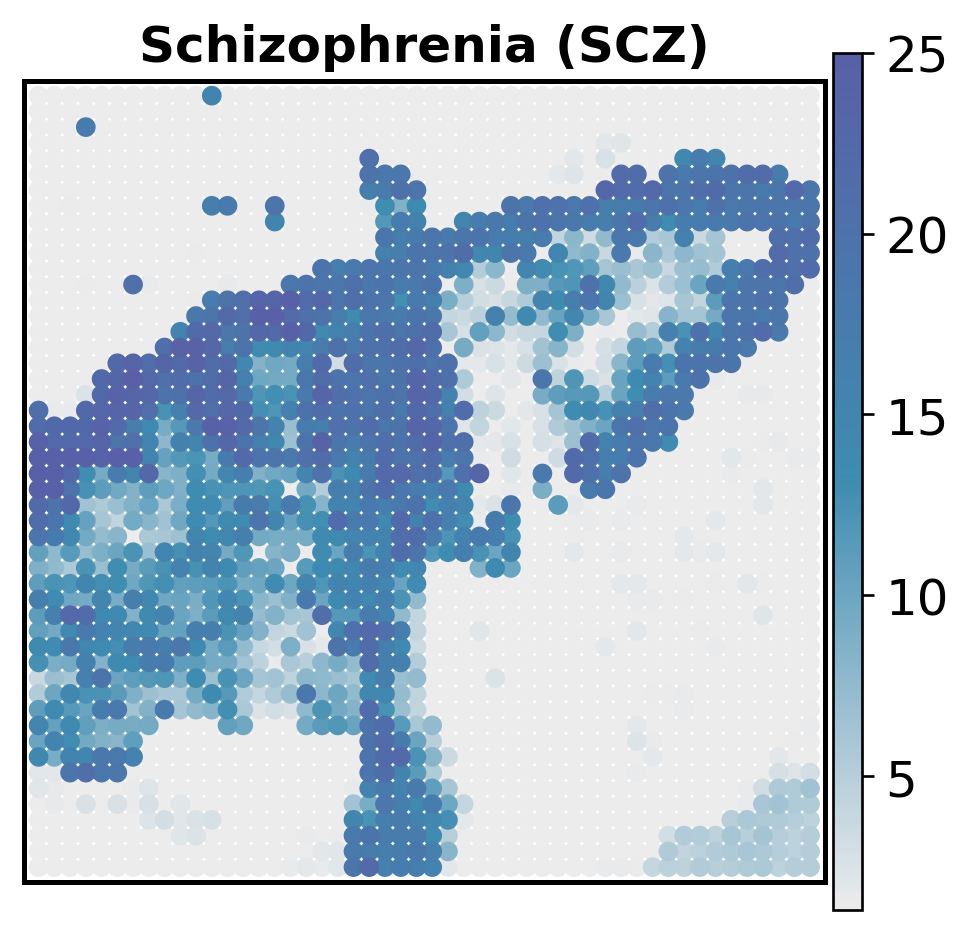

In [ ]:
# rotate the spatial coordinates 90 degrees counterclockwise
adata_rna.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(adata_rna.obsm['spatial'])

fb=ov.pl.ForbiddenCity()
colors=[
    fb.get_color_rgb('缟羽'),
    (62, 140, 177),
     (88, 96, 167),
]
#                       
fig, ax = plt.subplots(figsize=(4.7, 4.7))
ax = sc.pl.spatial(adata_rna,
              cmap=fb.get_cmap_seg(colors),
              color=['logp'], 
              title='',
              spot_size=1.25,legend_fontsize=12,vmax=25,vmin=-np.log10(0.05),
              show=False,ax=ax,
             ) 
ax[0].set_title('Schizophrenia (SCZ)', fontweight='bold',fontsize=15)  
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
ax[0].set_xlim(xmin + 0.04*(xmax-xmin), xmax - 0.04*(xmax-xmin))  
ax[0].set_ylim(ymin + 0.04*(ymax-ymin), ymax - 0.04*(ymax-ymin))

for spine in ax[0].spines.values():
    spine.set_linewidth(1.5) 

for cbar in ax[0].figure.axes:
    if isinstance(cbar, plt.Axes) and cbar.get_ylabel() == '':  
        cbar.tick_params(axis='y', labelsize=15) 
        break
            
ax[0].set_xlabel('', fontsize=15)
ax[0].set_ylabel('', fontsize=15)

### Visualizaion of GRNs

First, we preprocess the GWAS summary statistics file and calculate the GRN weights for our genes of interest.

In [ ]:
gwas_file = "../path/to/your/PGC3_SCZ_wave3_public_INFO80.txt"  # path to GWAS sumstats file (in report)
ref_dir = "Drive/Datasets/Reference/human_v42/snp"
gtf_file = "Drive/Datasets/Reference/human_v42/gencode.v42.annotation.gtf.gz"
output_file = "Drive/Datasets/Human_Hippocampus/Process_Data/PGC3_SCZ_wave3_public_INFO80.txt"

gwas_sumstats = ST.pp.process_gwas_sumstats(gwas_file,output_file, ref_dir)

In [ ]:
grn_weight = {}
for TF_id in ['TCF4','MYT1L','NEUROD2',]:
    print(f'Calculate the GRN weight of {TF_id}.')
    grn_weight[TF_id] = ST.pp.grn_weight(adata_rna, tf_gene=TF_id, n_jobs=10)
ov.utils.save(grn_weight,'Drive/Datasets/Human_Hippocampus/Process_Data/TCF4_MYT1L_NEUROD2_grn_weight.pkl')

In [ ]:
gwas_sumstats = pd.read_csv('Drive/Datasets/Human_Hippocampus/Process_Data/PGC3_SCZ_wave3_public_INFO80.txt',sep='\t')
gwas_sumstats

,SNP,A1,A2,freq,b,se,p,n,chrom,start,end,Unknown,strand,BP,CHR
0,rs12034030,C,T,0.71450,0.004500,0.0101,0.657700,73174,chr1,68212076.0,68212077.0,0.0,+,68212076.0,1.0
1,rs114605216,T,C,0.95800,-0.016404,0.0232,0.480900,61397,chr1,68763203.0,68763204.0,0.0,+,68763203.0,1.0
2,rs12079616,A,G,0.97700,-0.031800,0.0289,0.270700,59599,chr1,65523385.0,65523386.0,0.0,+,65523385.0,1.0
3,rs78832141,A,G,0.98000,0.029899,0.0330,0.365400,53711,chr1,66194843.0,66194844.0,0.0,+,66194843.0,1.0
4,rs12087596,C,T,0.08995,0.016700,0.0136,0.218200,73174,chr1,68957731.0,68957732.0,0.0,+,68957731.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6889749,rs118013066,T,C,0.97000,-0.014596,0.0242,0.547700,71974,chr22,50241248.0,50241249.0,0.0,+,50241248.0,22.0
6889750,rs139835,C,T,0.92700,-0.023699,0.0151,0.117400,73174,chr22,49758359.0,49758360.0,0.0,+,49758359.0,22.0
6889751,rs77785161,G,C,0.96100,-0.023504,0.0212,0.269000,73174,chr22,49769240.0,49769241.0,0.0,+,49769240.0,22.0
6889752,rs12484068,C,T,0.75050,-0.023903,0.0092,0.009507,72993,chr22,50661433.0,50661434.0,0.0,+,50661433.0,22.0


Then, by using `ST.pp.associate_snp_with_tf_regulatory_peaks()`, we are going to find the SNPs that are related to the specific genes.

In [ ]:
gtf_file = "Drive/Datasets/Reference/human_v42/gencode.v42.annotation.gtf"
grn_weight = ov.utils.load('Drive/Datasets/Human_Hippocampus/Process_Data/TCF4_MYT1L_NEUROD2_grn_weight.pkl')
target_gene_snp_dict = ST.pp.associate_snp_with_tf_regulatory_peaks(
            adata_rna.uns['regulatory_peaks'], 
            grn_weight, 
            gwas_data=gwas_sumstats,
            gtf_path=gtf_file
        )

Processing 3 transcription factors and 212 target genes
Loading protein-coding regions from GTF file: ../GoogleDrive/Reference/human_v42/gencode.v42.annotation.gtf


Parsing GTF file: 3413846it [00:11, 302200.41it/s]


Loaded 235058 protein-coding regions across 25 chromosomes


Finding SNPs in regulatory peaks: 100%|██████████| 212/212 [00:00<00:00, 1019.06it/s]

Found SNPs for 149/212 genes (70.3%)


We then use `ST.pp.identify_significant_snps()` to filter SNPs that are strongly associated with specific genes for further analysis.

In [22]:
significant_snps = ST.pp.identify_significant_snps(
        regulatory_peaks=adata_rna.uns['regulatory_peaks'], 
        grn_weight=grn_weight,
        gwas_data=gwas_sumstats,
        gtf_path=gtf_file,
        significance_threshold=2,
    )

Processing 3 transcription factors and 212 target genes
Loading protein-coding regions from GTF file: ../GoogleDrive/Reference/human_v42/gencode.v42.annotation.gtf


Parsing GTF file: 3413846it [00:06, 562264.71it/s]


Loaded 235058 protein-coding regions across 25 chromosomes
Using significance threshold: -log10(p) > 2 (p < 1.00e-02)


Finding significant SNPs in TF regulatory peaks: 100%|██████████| 212/212 [00:00<00:00, 838.96it/s]

Found 43 significant SNPs across 23/212 genes (10.8%)
Average of 1.9 significant SNPs per gene with SNPs


Here, we filter the regulatory relationships to include only those where the target gene is significantly regulated by a notable SNP. If no important SNPs exist near a target gene regulated by a transcription factor (TF), that regulatory relationship is removed. This filtering creates a focused network containing only the core components related to GWAS signals.

In [26]:
grn_weight_filter = {}
for tf, targets in grn_weight.items():
    if tf in grn_weight.keys():
        grn_weight_filter[tf] = {}
        
        for target, weight in targets.items():
            if target in significant_snps.keys():
                grn_weight_filter[tf][target] = weight

Visualization of GRNs regulated by selected TFs (TCF4, NEUROD2, and MYT1L). Only target genes harboring SNPs with P <0.01 are shown. Node color indicates the P-value of the associated SNPs. NCAM1 is highlighted in red for emphasis in downstream analysis.

In [27]:
def set_weights_to_one_and_adjust(grn_weight):
    from copy import deepcopy
    """Set all the weights in the GRN_weight dictionary to 1 and adjust by the number of TFs regulating the same gene."""
    modified_grn = deepcopy(grn_weight)
    gene_count = {}
    # Count how many TFs regulate each gene
    for tf, targets in modified_grn.items():
        for target in targets:
            if target in gene_count:
                gene_count[target] += 1
            else:
                gene_count[target] = 1
    
    # Set all weights to 1 and adjust by the number of TFs regulating the same gene
    for tf, targets in modified_grn.items():
        for target in targets:
            if isinstance(targets[target], list) and targets[target]:  # Ensure weight is a non-empty list
                targets[target][0] = 1.0 / gene_count.get(target, 1)  # Set weight to 1 divided by the count of TFs regulating the target
    
    return modified_grn
grn_weight_filter_updated = set_weights_to_one_and_adjust(grn_weight_filter)

Text(0.5, 1.0, 'GRN for Schizophrenia GWAS data')

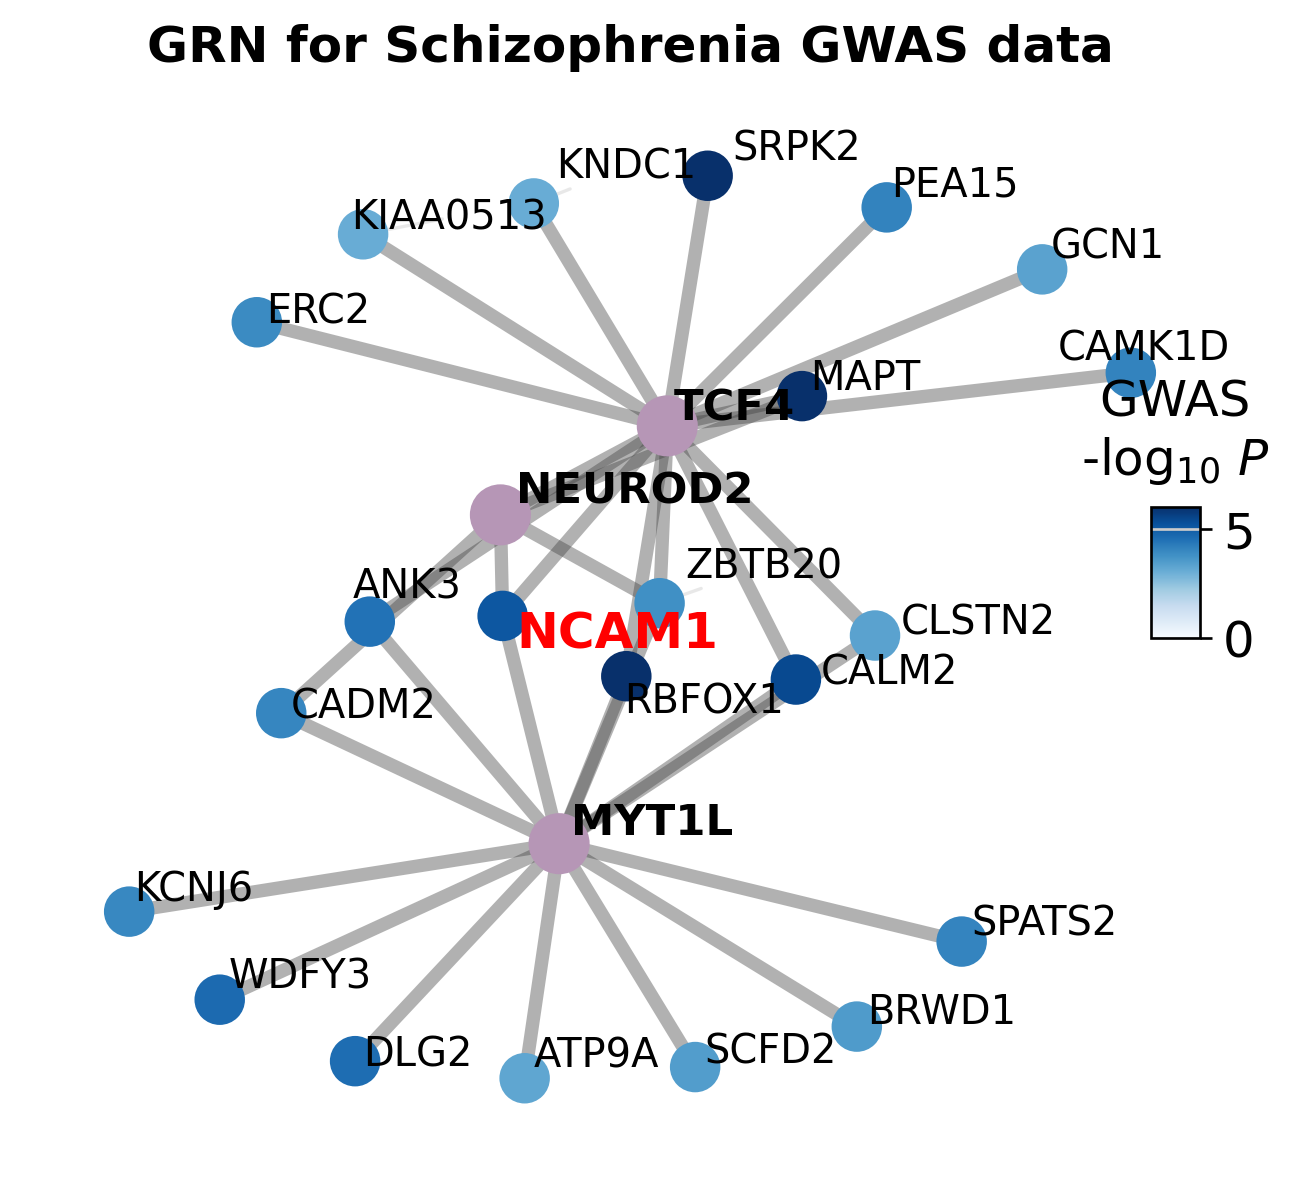

In [28]:
edge_color_dict = {'TCF4': '#3e3e3e', 
                   'NEUROD2': '#3e3e3e', 
                   'MYT1L': '#3e3e3e',}

G, G_type_dict, G_color_dict = ST.pl.create_gwas_network(
        grn_weight_dict = grn_weight_filter_updated,
        gene_snp_dict = target_gene_snp_dict,
        node_colors = {'tf_color': '#B696B6',
                      'target_color':'#000000'},
        max_targets_per_tf=500,
        vmin=-2,
        vmax=6,
        colormap='Blues', 
    )    
fig, ax = ST.pl.gwas_grn_network(
        G, 
        G_type_dict, 
        G_color_dict, 
        grn_weight_filter_updated,
        target_gene_snp_dict,
        edge_color_dict,
        specific_gene='NCAM1',
        figsize=(5.5, 5),
        edge_alpha=0.4,
        node_linewidths=1,
        node_alpha=1,
        show_colorbar=True,
        target_fontsize=12,
        TF_fontsize=13,
        TF_size=300,
        target_size=200,
        colormap='Blues', 
        show_legend=False,
        legend_fontsize  = 15,
        colorbar_bbox=(-0.05,0.25,2,0.6),
        vmin=0,
        vmax=6,
        label_log10pval_threshold=2,
    )
ax.set_title('GRN for Schizophrenia GWAS data', fontweight='bold',fontsize=15)  

### Visualization of Peak2GeneLinks

To visualize the regulatory landscape around our gene of interest, `NCAM1`, we first extract its coordinates from a GTF annotation file. We then create a track-plotting object that incorporates multiple data sources: BigWig files showing chromatin accessibility across different brain regions, a BED file containing all regulatory peak locations, and a file specifying the Peak2Gene links.

In [ ]:
gtf_pathway = "Drive/Datasets/Reference/human_v42/gencode.v42.annotation.gtf"
gtf_df = ST.pp.load_gtf(gtf_pathway, adata_rna.var_names)
gtf_df

bw_dict={
    'Peak2GeneLink':'Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/peak2gene.links',
    'Peak':"Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/peaks.bed",
    'GCL':"Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/GCL.bw",
    'CA3-4':'Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/CA3_4.bw',
    'CA_Other': 'Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/Other.bw',
    'ML':'Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/ML.bw',
    'CP':'Drive/Datasets/Human_Hippocampus/Process_Data/Process_Data/ATAC/CP.bw',
}
bw_obj=ST.external.epiverse.bigwig(bw_dict)
bw_obj.read()
bw_obj.load_gtf(gtf_pathway)

......Loading Peak2GeneLink
......Loading Peak
......Loading GCL
......Loading CA3-4
......Loading CA_Other
......Loading ML
......Loading CP
......Loading gtf file


To get the precise location of the NEUROD2 binding site, we computationally scan the genomic sequence around our SNP. We check small, overlapping segments of DNA against the known NEUROD2 binding motif, allowing us to pinpoint the exact coordinates of the statistical match.

In [ ]:
def split_region(region, window_size=10):
    # 解析区域字符串
    chrom, pos_str = region.split(':')
    start, end = map(int, pos_str.split('-'))
    
    # 计算分割后的区域
    regions = []
    current_start = start
    while current_start + window_size - 1 <= end:
        current_end = current_start + window_size 
        regions.append(f"{chrom}:{current_start}-{current_end}")
        current_start += 1
    
    return regions

import snapatac2 as snap
from pyfaidx import Fasta

annotation_pathway = 'Drive/Datasets/Reference/human_v42/gencode.v42.basic.annotation.gff3'
fasta_pathway = 'Drive/Datasets/Reference/human_v42/GRCh38.primary_assembly.genome.fa'
genome_fasta = snap.genome.Genome(fasta=fasta_pathway,
                                      annotation = annotation_pathway)
genome = Fasta(genome_fasta.fasta, one_based_attributes=False)

region = 'chr11:113077429-113077930'
window_size = 10

split_regions = split_region(region, window_size)

motif_pathway = 'Drive/Datasets/Reference/human_v42/cisBP_human.meme'
motif_list = ST.grn.read_motif(motif_pathway)

TF_candidate = ['NEUROD2']
filtered_motifs = [motif for motif in motif_list if motif.name in TF_candidate]
filtered_motifs

for motif in filtered_motifs:
    print(motif.id)
    for id, region in enumerate(split_regions, 1):
        sequences = ST.grn.fetch_seq(genome, region)
        bound = motif.with_nucl_prob().exists([sequences], pvalue=1e-4)[0]
        if bound:
            print(id) 
            print(region)  # 113077583 rs1965775 G→A

NEUROD2+M04160_2.00
148
chr11:113077576-113077586


Now we can visualize chromatin accessibility profiles of the genomic region spanning NCAM1 across different spatial domains. Peak2GeneLinks appear as arches, color-coded by the statistical significance of their correlations. These links were derived from correlations between chromatin accessibility peaks and gene expression across metacells from all spatial spots. The NEUROD2 binding peak, identified with the SnapATAC2 toolkit and overlapping with significant SNP rs1465765, is highlighted in a red box.

Text(0.8, 0.15, 'chr11:112,951,246-113,081,246')

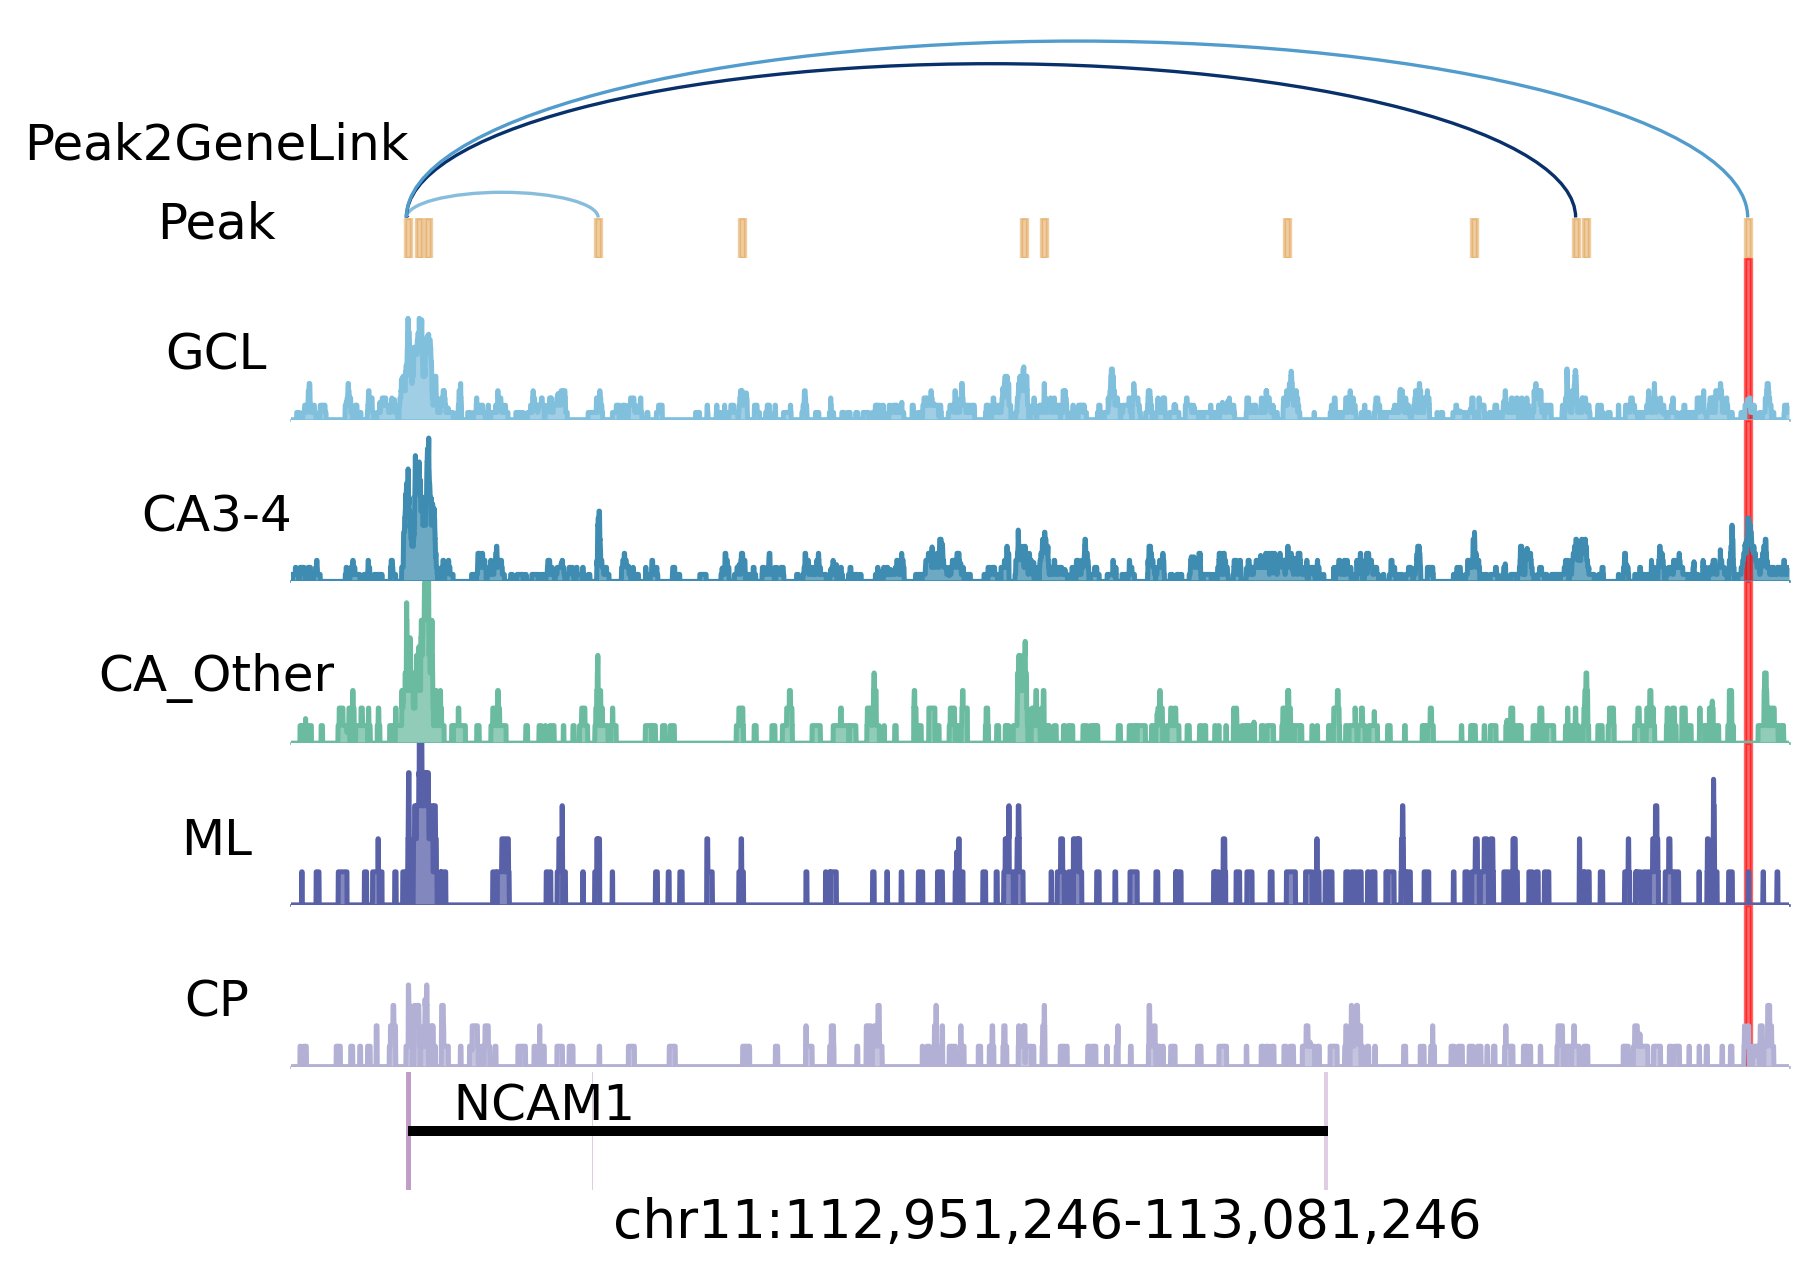

In [18]:
loc = gtf_df.loc["NCAM1"]
chrom = loc["chrom"]
chromLen = 40000
chromStart = loc["chromStart"] - 10000
chromEnd = loc["chromStart"] + 120000
region_dict={
    'region1':[113077429,113077930],
}

region_color_dict={
    'region1':'#FF0000',
  #  'region2':'#7EA2DF',
}

color_dict={
    'Peak':'#E19D49',
    'GCL':'#81C0DD', 
    'CA3-4':'#3E8CB1', 
    'CA_Other':'#6BBBA0',
    'CP':'#B2B0D4',
    'ML':'#5860A7',
}

subplot_height_ratios=[1.2,0.25,
                       1,1,1,1,1,
                       0.8,0]

fig,ax = bw_obj.plot_track(chrom=chrom,chromstart=chromStart,chromend=chromEnd,
                  nbins=int((chromEnd-chromStart)/10),
                  plot_names=['Peak2GeneLink','Peak','GCL','CA3-4','CA_Other','ML','CP',],
                  figwidth=8,figheight=5,
                  value_type='sum',
                  subplot_height_ratios=subplot_height_ratios,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  region_color_dict=region_color_dict,
                  spines=False,
                  prefered_name='gene_name',
                  ymax=15,
                  text_height=1,
                  text_length=0.5,
                  plus_gtf_color='#C19CC8',
                  minus_gtf_color='#9DB1DF',
                  #show_text='rowlabel',
                  ylabel_coords=(-0.05,0.25),
                  text_fontsize=15,
                  title_location=0.9,
                  cmap=plt.cm.Blues,
                  plot_arrow = False,
                  vmax=2,
                  plot_ymax=False,
                 )
plt.suptitle('{}:{:,}-{:,}'.format(chrom,chromStart,chromEnd),x=0.8,y=0.15,fontsize=16,horizontalalignment='right')

Here we zoom in to examine the chromatin accessibility profiles across spatial domains for the genomic region containing the predicted NEUROD2 binding peak (highlighted in yellow). The SNP rs1465765 is marked by a semi-transparent box.

Text(0.85, 0.15, 'chr11:113,076,929-113,078,430')

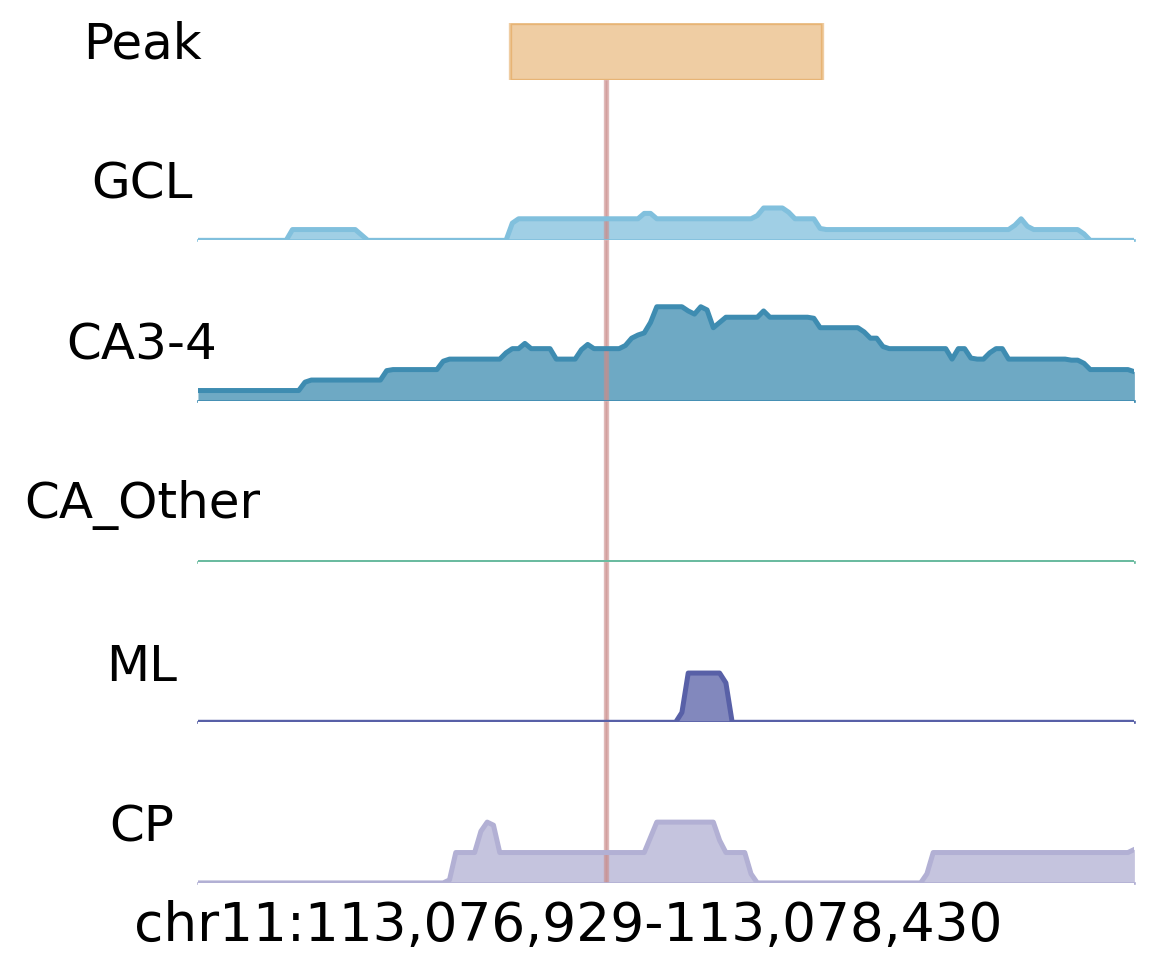

In [19]:
loc = gtf_df.loc["NCAM1"]
chrom = loc["chrom"]
chromLen = 40000
chromStart = 113077429 - 500
chromEnd = 	113077930 + 500

region_dict={
    'region2':[113077583-1,113077583+1],
}

region_color_dict={
    'region2':'#CB8D8B',
}


color_dict={
    'Peak':'#E19D49',
    'GCL':'#81C0DD', 
    'CA3-4':'#3E8CB1',   
    'CA_Other':'#6BBBA0',
    'CP':'#B2B0D4',
    'ML':'#5860A7',
}

subplot_height_ratios=[0.35,
                       1,1,1,1,1,
                       0,0.1]

fig,ax = bw_obj.plot_track(chrom=chrom,chromstart=chromStart,chromend=chromEnd,
                  nbins=int((chromEnd-chromStart)/10),
                  plot_names=['Peak','GCL','CA3-4','CA_Other','ML','CP',],
                  figwidth=5,figheight=3.6,
                  value_type='sum',
                  subplot_height_ratios=subplot_height_ratios,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  region_color_dict=region_color_dict,
                  spines=False,
                  prefered_name='gene_name',
                  ymax=10,
                  text_height=1,
                  text_length=0.5,
                  plus_gtf_color='#C19CC8',
                  minus_gtf_color='#9DB1DF',
                  #show_text='rowlabel',
                  ylabel_coords=(-0.06,0.2),
                  text_fontsize=15,
                  title_location=0.9,
                  cmap=plt.cm.Blues,
                  vmax=2,
                  plot_ymax=False,
                 )
plt.suptitle('{}:{:,}-{:,}'.format(chrom,chromStart,chromEnd),x=0.85,y=0.15,fontsize=16,horizontalalignment='right')

Finally, we visualize the NEUROD2 motif logo, which shows both reference and alternative alleles, with the mutation site marked by a gray box.

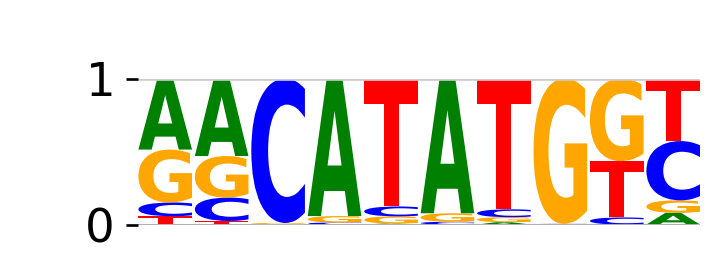

In [ ]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt

# Create dataframe from your matrix
matrix = [
    [0.486503856041131, 0.0944730077120823, 0.362467866323907, 0.0565552699228792],
    [0.530864197530864, 0.160493827160494, 0.284567901234568, 0.0240740740740741],
    [0, 0.989513108614232, 0.0104868913857678, 0],
    [0.942225392296719, 0.0135520684736091, 0.0442225392296719, 0],
    [0.006635700066357, 0.0676841406768414, 0.0491041804910418, 0.87657597876576],
    [0.923130677847659, 0.0188679245283019, 0.0580013976240391, 0],
    [0.0156037991858887, 0.05359565807327, 0.0345997286295794, 0.896200814111262],
    [0, 0.00452147701582517, 0.995478522984175, 0],
    [0, 0.0482708933717579, 0.565561959654179, 0.386167146974063],
    [0.0795957043588124, 0.406190777005685, 0.0859128237523689, 0.428300694883133]
]
df = pd.DataFrame(matrix, columns=list('ACGT'))

# Create logo
logo = logomaker.Logo(df, color_scheme='classic',figsize=(3,0.8),)

# Style the logo
logo.style_spines(visible=False)
logo.ax.set_ylabel(' ',fontsize=15)
plt.xticks([])
logo.ax.set_title(' ')
plt.show()